In [9]:
%matplotlib notebook
# does not work in colab

## Mandelbrot set

 Mandelbrot set is the set of values of c for which <br>
$ z_{n+1} = z_{n}^{2} + c $ &emsp; remains bounded

More specifically, a point $c$ belongs to the Mandelbrot set if and only if  <br>
$|z_{n}|\leq 2$ &emsp; for all &emsp; $n\geq 0$

More information can be found here:
- https://en.wikipedia.org/wiki/Mandelbrot_set

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from tqdm.notebook import tqdm
import time
from matplotlib.animation import FuncAnimation

### define parameters

In [11]:
# define size
# using top left and bottom right coordinates
img_size = ((0,0),(600,400))
frac_size = ((-2,-1),(1,1))
(frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
(img_x0,img_y0), (img_x1,img_y1) = img_size
img_w = img_x1 - img_x0
img_h = img_y1 - img_y0

# define parameters
maxIter = 100
frac_xStep = (frac_x1-frac_x0)/(img_x1-img_x0)
frac_yStep = (frac_y1-frac_y0)/(img_y1-img_y0)
params = {"maxIter":maxIter, "frac_xStep":frac_xStep, "frac_yStep":frac_yStep}    

### plot fractal

In [12]:
def imgToFrac(frac_size,img_size,point):
  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_x1 -= 1.0;  img_y1 -= 1.0

  x0, y0 = point
  x1 = (x0-img_x0)*(frac_x1-frac_x0)/(img_x1-img_x0) + frac_x0
  y1 = (y0-img_y0)*(frac_y0-frac_y1)/(img_y1-img_y0) + frac_y1
  return x1,y1

def fracToImg(frac_size,img_size,point):
  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_x1 -= 1;  img_y1 -= 1

  x0, y0 = point
  x1 = int(round((x0-frac_x0)*(img_x1-img_x0)/(frac_x1-frac_x0) + img_x0))
  y1 = int(round((y0-frac_y0)*(img_y0-img_y1)/(frac_y1-frac_y0) + img_y1))
  return x1,y1

def plot_frac(frac_size,img_size,params):

  (frac_x0,frac_y0), (frac_x1,frac_y1) = frac_size
  (img_x0,img_y0), (img_x1,img_y1) = img_size
  img_w = img_x1 - img_x0
  img_h = img_y1 - img_y0

  img = np.zeros((img_h, img_w, 3))   # create a blank np array to hold the image
  for x in tqdm(np.arange(frac_x0, frac_x1+params["frac_xStep"], params["frac_xStep"])):    # have added step size to endpoints to include them
    for y in np.arange(frac_y0, frac_y1+params["frac_xStep"], params["frac_yStep"]):
      
      c = x+y*1j
      z = c

      for i in range(params["maxIter"]):
        z = z**2 + c
        if abs(z) > 2:
            break
      # color depends on the number of maxIter
      h = i/(params["maxIter"] - 1)
      s = 1
      v = 1 - i/(params["maxIter"]-1)  # points taking longer to converge should appear darker (more black)
      # assign in np array
      i,j = fracToImg(frac_size,img_size,(x, y))
      img[j][i] = np.array([h,s,v])
  
  return hsv_to_rgb(img)

In [13]:
img = plot_frac(frac_size,img_size,params)
# plt.imshow(img);  plt.show()

add axes

<IPython.core.display.Javascript object>


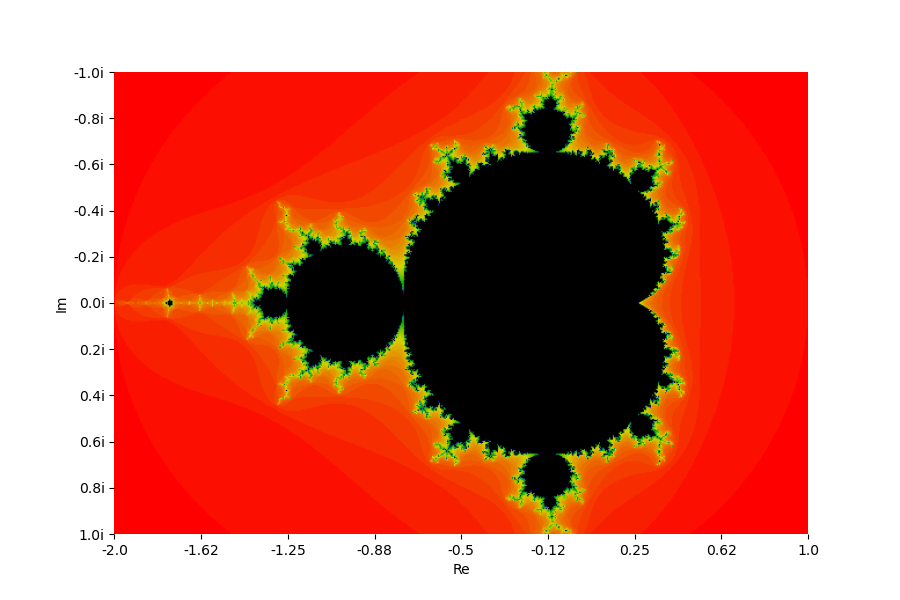

In [15]:
def show_img(ax,img):
    ax.imshow(img)
    xlen = len(ax.get_xticks())
    ylen = len(ax.get_yticks())
    xlen += (xlen+1)%2; ylen += (ylen+1)%2
    xticks = np.linspace(img_x0,img_x1-1,xlen)
    yticks = np.linspace(img_y0,img_y1-1,ylen)
    xlabels = np.round(np.linspace(frac_x0,frac_x1,xlen),2)
    ylabels = np.round(np.linspace(frac_y1,frac_y0,ylen),2)
    ylabels = [str(l)+'i' for l in ylabels]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Re")
    ax.set_ylabel("Im")
    ax.set_frame_on(False)
    ax.set_xlim([img_x0,img_x1-1])
    ax.set_ylim([img_y0,img_y1-1])






fig, ax = plt.subplots(1, figsize=(9,6))
show_img(ax,img)
#line1, = ax.plot([0],[0], linewidth=1)
#text = ax.text(0,0, "", va="bottom", ha="left")
def mouse_move(event):
    x, y = event.xdata, event.ydata  
    
    t_ms = time.time()*10 % 10
    if t_ms > 1.5:
        
        ax.cla()
        show_img(ax,img)        
        x, y = imgToFrac(frac_size,img_size,(x, y))

        orbit = []

        c = x + y*1j
        z = c
        for i in range(params["maxIter"]):
            orbit.append(fracToImg(frac_size,img_size,(z.real, z.imag)))
            z = z**2 + c
            if abs(z) > 2:
                break

        x,y = np.array(list(zip(*orbit)))
        #line1.set_xdata(x)
        #line1.set_ydata(y)
        #tx = "%s" % (len(x))
        #text.set_text(tx)
        #ax.plot(x,y)

        u = x[1:] - x[:-1]
        v = y[1:] - y[:-1]
        ax.quiver(x[:-1],y[:-1],u,v, scale_units='xy', angles='xy', scale=1, width=0.001, headwidth=10, color='blue')
        #ax.scatter(x[-1],y[-1], s=10)

        #fig.canvas.draw()
        #fig.canvas.flush_events()

cid = fig.canvas.mpl_connect('motion_notify_event', mouse_move)
#cid = fig.canvas.mpl_connect('button_press_event', mouse_move)

<IPython.core.display.Javascript object>


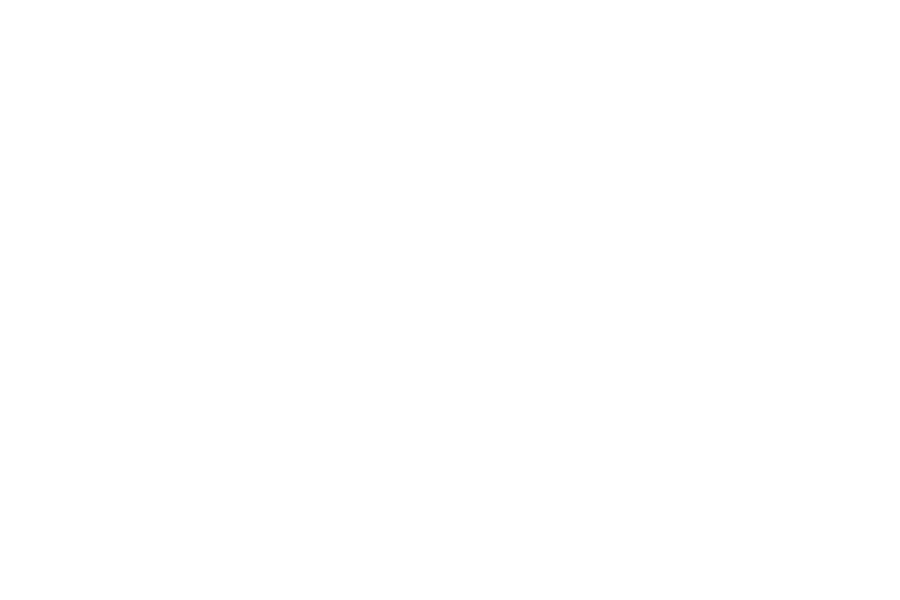

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


KeyboardInterrupt: 

In [7]:
frames = 1000
# animation function 
def animate(i): 
    ax.cla()
    show_img(ax,img)   
    
    t = (i/frames)*2*np.pi
    c = (np.exp(t*1j)*(2-np.exp(t*1j))/4)*0.98  # slightly off the boundary of cardioid
    x,y = c.real, c.imag

    orbit = []

    c = x+y*1j
    z = c
    for i in range(params["maxIter"]):
        orbit.append(fracToImg(frac_size,img_size,(z.real, z.imag)))
        z = z**2 + c
        if abs(z) > 2:
            break

    x,y = np.array(list(zip(*orbit)))
    #line1.set_xdata(x)
    #line1.set_ydata(y)

    u, v = x[1:] - x[:-1], y[1:] - y[:-1]
    ax.quiver(x[:-1],y[:-1],u,v, scale_units='xy', angles='xy', scale=1, width=0.001, headwidth=10, color='blue')
    ax.scatter(x[0],y[0], s=10, c='w')
    
# call the animator
fig, ax = plt.subplots(1, figsize=(9,6))
#show_img(ax,img)
line1, = ax.plot([0],[0], linewidth=1)
anim = FuncAnimation(fig, animate, frames=frames)
anim.save('mandel.gif', writer='pillow', fps=10, progress_callback=lambda i, n: print(i),)